In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

c:\Users\tmntn\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\tmntn\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
C:\Users\tmntn\AppData\Local\Temp\ipykernel_10364\3102821532.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Naive ARMA Forecast
In this section we experiment with forecasting the values of certain quantities such as the opening and close price of the stock for the day, as well as the highest and lowest price of the stock for that day. We do this constructing a basic ARMA model.

In [2]:
def arma_forecast_naive(filename="./coca-cola.npy", p=2, q=1, n=20, quantity="Open"):
    """
    Perform ARMA(p,q) on data. Let error terms be drawn from
    a standard normal, let c be 0, the phis be 0.5, and the 
    thetas be 0.1. Predict the next n observations and plot 
    the original data with the predictions.

    Parameters:
        file (str): data file
        p (int): order of autoregressive model
        q (int): order of moving average model
        n (int): number of future predictions
    """
    data = np.load(filename)
    # Just selecting the open prices
    # Close prices is [1:,4]
    # High prices is [1:,2]
    # Low prices is [1:,3]
    if quantity == "Open":
        data = data[1:,1]
    elif quantity == "Close":
        data = data[1:,4]
    elif quantity == "High":
        data = data[1:,2]
    elif quantity == "Low":
        data = data[1:,3]
    # Initialize variables Z, k, phi, thetam c, sigma, and epsilon
    Z = np.diff(data).tolist()
    k = len(Z)-1
    phi, theta = .5, .1
    c, sigma = 0, 1
    eps = list(np.random.normal(0, sigma, k))
    # Iterating through k -> k+n to get the forcasted data
    for t in range(k, k+n):
        # Appending to epsilon
        eps.append(np.random.normal(0, sigma))
        # Calculating AutoRegressive sum
        AR = np.sum([phi*Z[t-i] for i in range(p)])
        # Calculating Moving Averages sum
        MA = np.sum([theta*eps[t-j] for j in range(q)])
        # Combining to form ARMA using equation for Z_t
        Zt = c + AR + MA + eps[t]
        Z.append(Zt)

    # Plotting
    plt.plot(np.diff(data), label="Old Data")
    plt.plot([x for x in range(k, k+n+1)], Z[k:], label="New Data")
    plt.xlim(15000, 16000)
    plt.title(f"ARMA(2,1) Naive Forecast on {quantity} Prices")
    plt.legend()
    plt.show()

    return Z

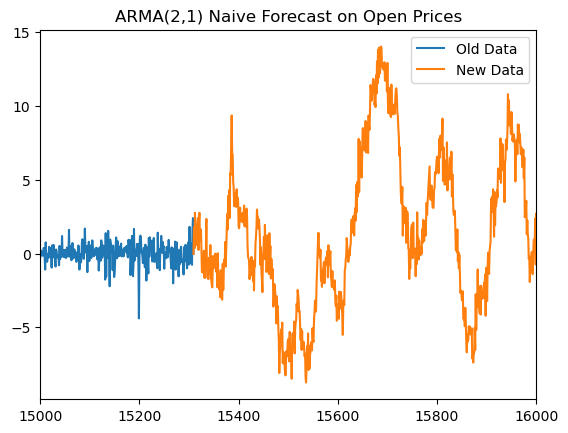

In [3]:
predictions = arma_forecast_naive(filename="./coca-cola.npy", p=2, q=1, n=1000, quantity="Open")

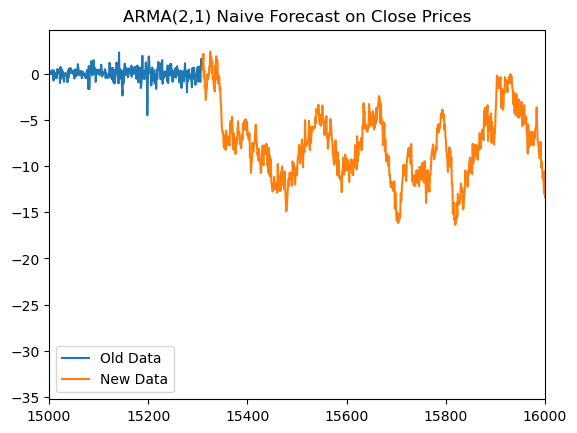

In [4]:
predictions = arma_forecast_naive(filename="./coca-cola.npy", p=2, q=1, n=1000, quantity="Close")

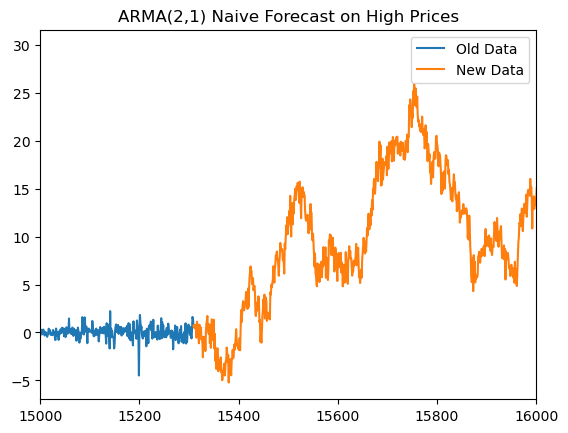

In [5]:
predictions = arma_forecast_naive(filename="./coca-cola.npy", p=2, q=1, n=1000, quantity="High")

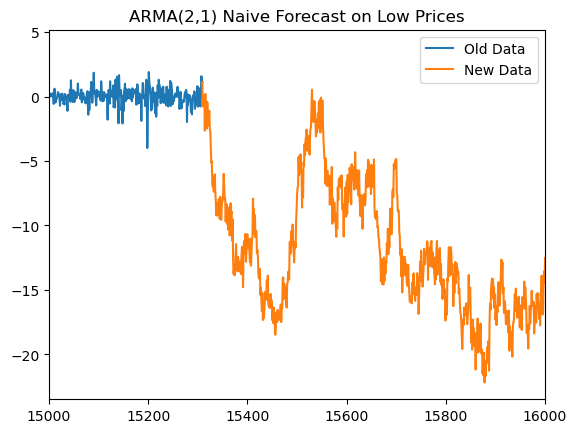

In [6]:
predictions = arma_forecast_naive(filename="./coca-cola.npy", p=2, q=1, n=1000, quantity="Low")

# Statsmodel ARIMA Forecast
Here we try to use the ARMIA() package from statsmodel to try and forecast the stock price values at opening, close, its highest and lowest proce, for the next 30 days.

In [7]:
def stats_model_arma(quantity="Open"):
    """
    Build an ARMA model with statsmodel and
    predict future n values.

    Parameters:
        filename (str): data filename
        p_max (int): maximum order of autoregressive model
        q_max (int): maximum order of moving average model
        n (int): number of values to predict

    Return:
        aic (float): aic of optimal model
    """
    df = pd.read_csv('./data/Coca-Cola_stock_history.csv')
    df['date'] = pd.to_datetime(df['Date'].str.split().str[0])
    df = df.drop(columns=['Date'])  

    # Loading data
    if quantity == "Open":
        df_open = df['Open']
        #df_log = np.log(df_open)
        train_data = df_open[3:int(len(df_open)*0.9)]
        # test_data = df_log[int(len(df_log)*0.9):]
    elif quantity == "Close":
        df_close = df['Close']
        #df_log = np.log(df_close)
        train_data = df_close[3:int(len(df_close)*0.9)]
        # test_data = df_log[int(len(df_log)*0.9):]
    elif quantity == "High":
        df_high = df['High']
        #df_log = np.log(df_high)
        train_data = df_high[3:int(len(df_high)*0.9)]
        # test_data = df_log[int(len(df_log)*0.9):]
    elif quantity == "Low":
        df_low = df['Low'] 
        #df_log = np.log(df_low)
        train_data = df_low[3:int(len(df_low)*0.9)]
        # test_data = df_log[int(len(df_log)*0.9):] 

    model = ARIMA(train_data, order=(1,1,2))
    model = model.fit()
    train_data_dates = pd.DataFrame(df['date'][3:int(len(df['date'])*0.9)], columns=['date'])
    start_date = '2016-09-27'
    end_date = '2017-01-05'
    date_range = pd.date_range(start=start_date, end=end_date)
    # Create DataFrame
    new_df = pd.DataFrame(date_range, columns=['date'])

    # Convert dates to the desired format
    new_df['date'] = new_df['date'].dt.strftime('%Y-%m-%d')
    total_data_date = pd.concat([train_data_dates, new_df], ignore_index=True)
    plt.plot(train_data_dates['date'], train_data, label="Old Data", c='blue', linewidth='1')
    plt.plot(total_data_date['date'], model.predict(start=0, end=len(train_data)+100), label="ARMA Model", c='y', linewidth='0.5')
    plt.title(f"Statsmodel ARMA(1,1) for {quantity} Prices")
    # Zoom in on open
    """
    plt.xlim(17000, 17250)
    plt.ylim(33,36)
    """
    plt.legend()
    plt.show()
                
    return model.aic

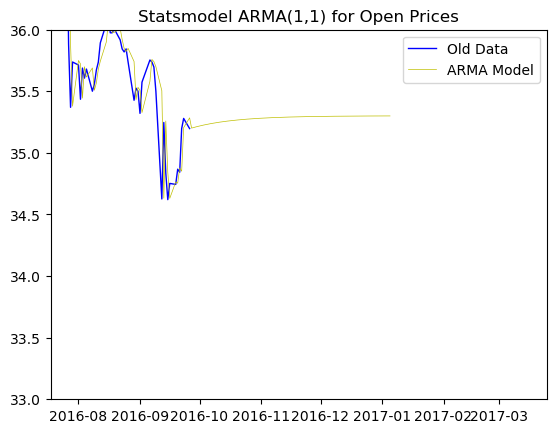

-12671.65170307686

In [8]:
stats_model_arma(quantity="Open")

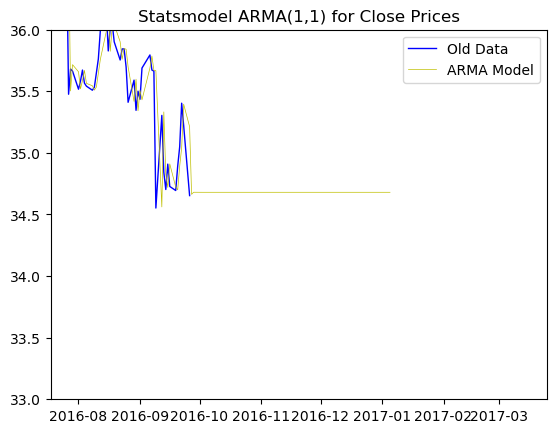

-11676.738957536663

In [9]:
stats_model_arma(quantity="Close")

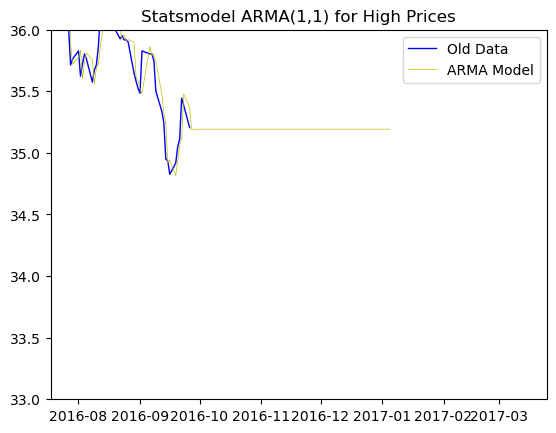

-15849.107953372011

In [10]:
stats_model_arma(quantity="High")

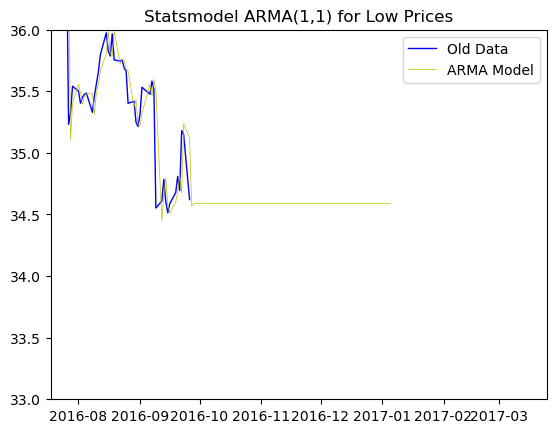

-14095.54679643901

In [11]:
stats_model_arma(quantity="Low")

In [12]:
def subplots():
    # Load and clean data
    df = pd.read_csv('./data/Coca-Cola_stock_history.csv')
    df['date'] = pd.to_datetime(df['Date'].str.split().str[0])
    df = df.drop(columns=['Date'])

    fig, ax = plt.subplots(1,2)
    # Figure 1 - Forecasting Closing prices for the second half of May 2014
    df_close_full = df['Close'].iloc[13174:13194]
    df_close_train = df_close_full[0:10]
    model_close = ARIMA(df_close_train, order=(3,1,1))
    model_close = model_close.fit()
    ax[0].plot(df_close_full, c='blue', linewidth='1')
    ax[0].plot(model_close.predict(start=0, end=(len(df_close_train)-1)+10), c='r', linewidth='0.5')
    #ax[0].plot(df['date'].iloc[13184], df['Close'].iloc[13184], c='g')
    ax[0].set_title("Closing Prices for May 2014")
    ax[0].set_ylim(30, 32)
    # Figure 2 - Testing how well our model does with high volitility, which according to the graphs of the entire time, 
    # happen between 1995 - 2005
    df_open_volitile_full = df['Open'].iloc[8308:11078]
    df_open_volitile_train = df_open_volitile_full[0:1800]
    model_open_volitile = ARIMA(df_open_volitile_train, order=(3,1,1))
    model_open_volitile = model_open_volitile.fit()
    ax[1].plot(df_open_volitile_full, c='blue', linewidth='1')
    ax[1].plot(model_open_volitile.predict(start=0, end=(len(df_open_volitile_train)-1)+900), c='r', linewidth='0.5')
    ax[1].set_title('Opening Prices 1995-2005')
    # Figure 3 - Forecasting massive changes
    plt.tight_layout()
    plt.show()

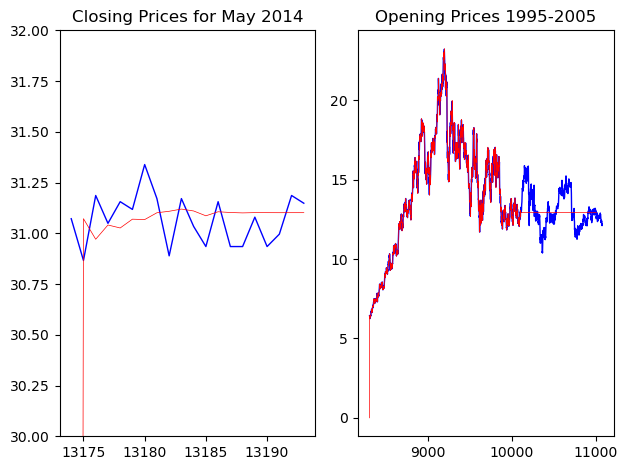

In [13]:
subplots()

# Messing aroung with Pandas

In [14]:
df = pd.read_csv('./data/Coca-Cola_stock_history.csv')
df['date'] = pd.to_datetime(df['Date'].str.split().str[0])
df = df.drop(columns=['Date'])
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,date
0,0.050016,0.051378,0.050016,0.050016,806400,0.0,0,1962-01-02
1,0.049273,0.049273,0.048159,0.048902,1574400,0.0,0,1962-01-03
2,0.049026,0.049645,0.049026,0.049273,844800,0.0,0,1962-01-04
3,0.049273,0.049892,0.048035,0.048159,1420800,0.0,0,1962-01-05
4,0.047787,0.047787,0.046735,0.047664,2035200,0.0,0,1962-01-08


## Visualize Closing Prices

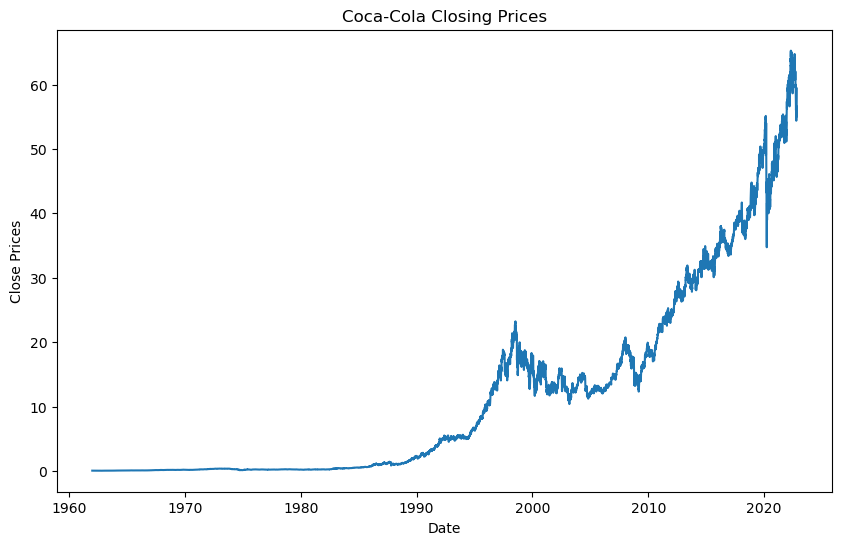

In [15]:
plt.figure(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df['date'], df['Close'])
plt.title('Coca-Cola Closing Prices')
plt.show()

## Probability Distribution of Closing Prices

<AxesSubplot:ylabel='Density'>

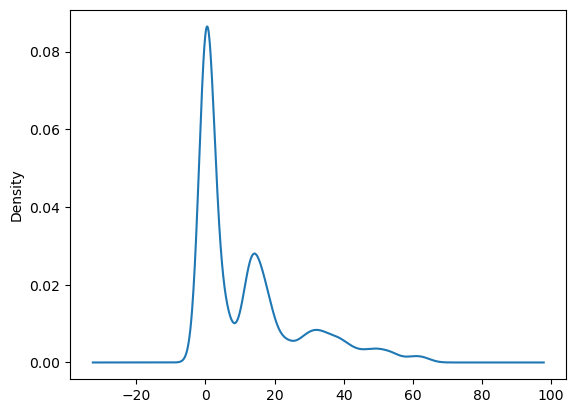

In [16]:
df_close = df['Close']
df_close.plot(kind='kde')

# Time Series Decomposition of Close Prices

<Figure size 640x480 with 0 Axes>

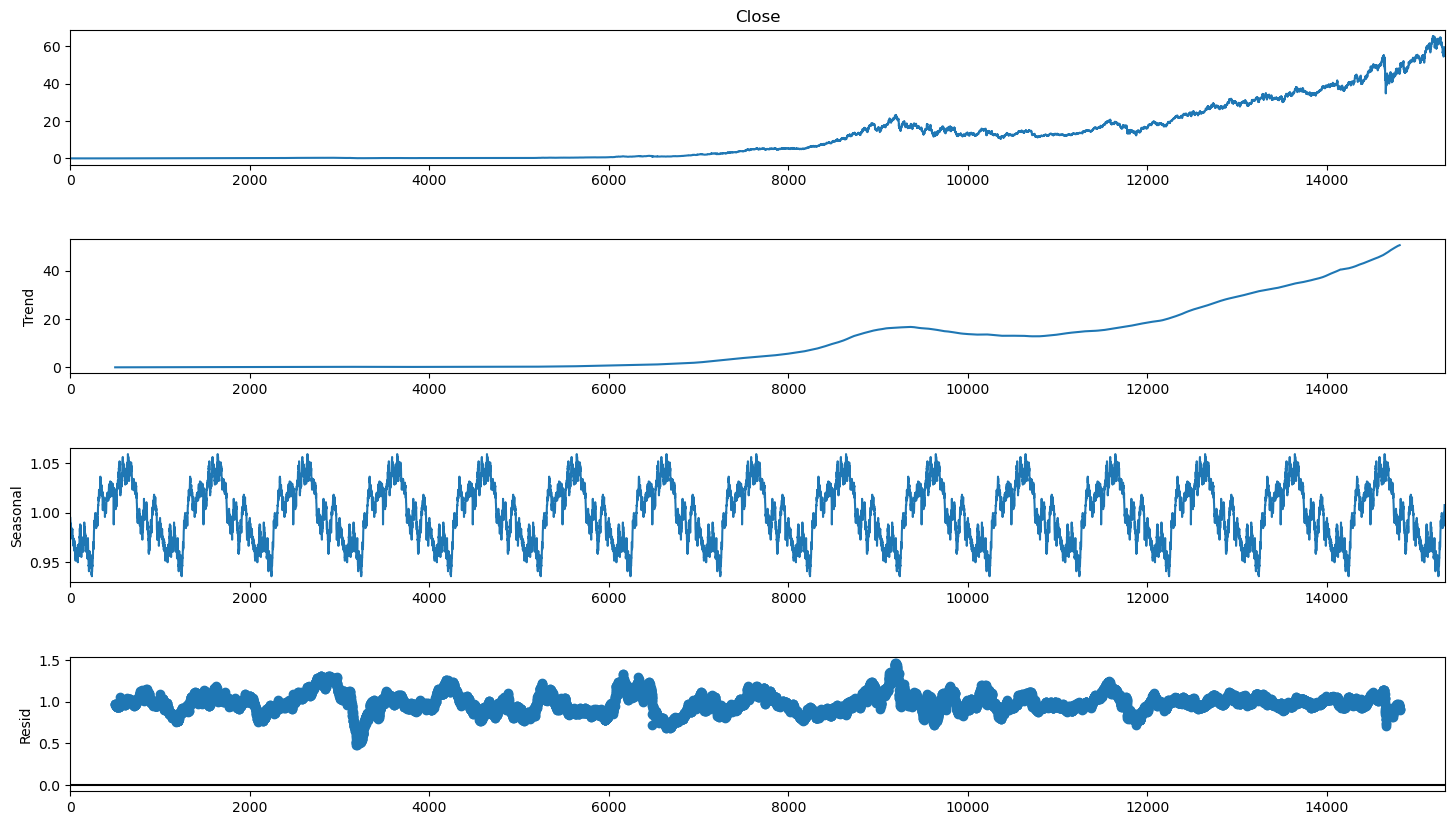

In [17]:
result = seasonal_decompose(df_close, model='multiplicative', period=1000)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

# Looking at the stock volume

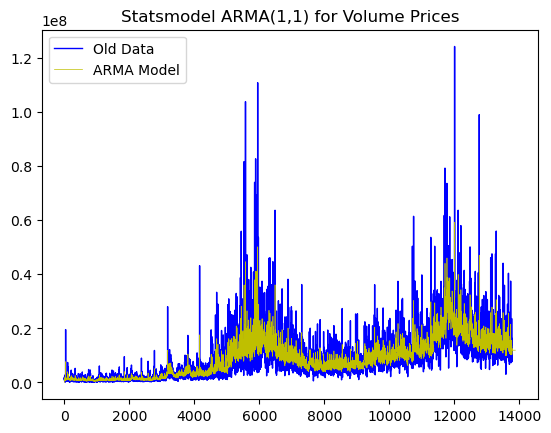

In [18]:
df_volume = df['Volume']
#df_log = np.log(df_close)
train_data, test_data = df_volume[3:int(len(df_volume)*0.9)], df_volume[int(len(df_volume)*0.9):]
model = ARIMA(train_data, order=(1,1,2))
model = model.fit()
plt.plot(train_data, label="Old Data", c='blue', linewidth='1')
plt.plot(model.predict(start=0, end=len(train_data)+100), label="ARMA Model", c='y', linewidth='0.5')
plt.title(f"Statsmodel ARMA(1,1) for Volume Prices")
plt.legend()
plt.show()